# Purpose

This notebook models the conditional mean of daily SPY returns using benchmark and ARIMA models, and evaluates out-of-sample forecasting performance.

The objective is to test whether simple time-series structure adds value beyond a naïve benchmark.

# Load data and libraries

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, root_mean_squared_error
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.stats.diagnostic import acorr_ljungbox

In [36]:
returns_df = pd.read_csv(
    "../data/processed/daily_returns.csv",
    index_col=0,
    parse_dates=True
)
returns_df.index = pd.to_datetime(returns_df.index)
returns_df = returns_df.sort_index()

returns = returns_df["adj_log_return"]

# Train / test split

In [7]:
split_date = "2022-01-01"

train = returns.loc[returns.index < split_date]
test  = returns.loc[returns.index >= split_date]

Training set: 2010–2021

Test set: 2022–2024

Chronological split to avoid look-ahead bias

# Baseline model

In [37]:
mean_return = train.mean()

In [38]:
baseline_forecast = np.repeat(mean_return, len(test))

In [39]:
baseline_mae = mean_absolute_error(test, baseline_forecast)
baseline_rmse = root_mean_squared_error(test, baseline_forecast)

baseline_mae, baseline_rmse

(0.008103520435626736, 0.011026151369086199)

# ARIMA model specification

Model choice logic:

* Returns are stationary

* Autocorrelation is weak

* Use low-order ARIMA

In [11]:
arima_model = ARIMA(train, order=(1, 0, 1))
arima_result = arima_model.fit()

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Higher-order specifications were avoided to reduce overfitting given weak serial dependence.

# Diagnostic checking

In [12]:
residuals = arima_result.resid

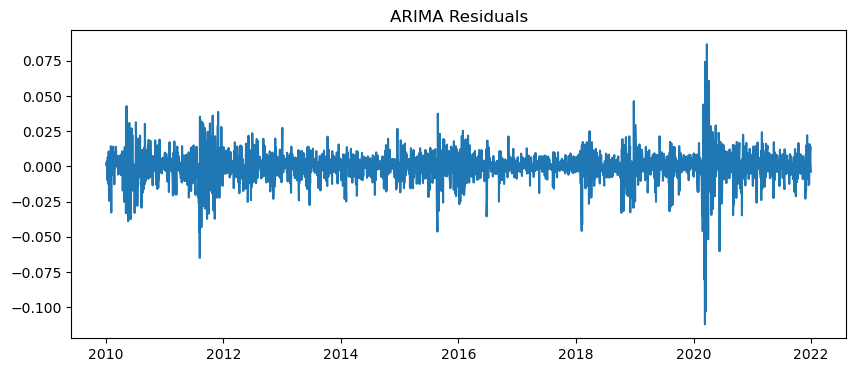

In [26]:
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.title("ARIMA Residuals")
plt.show()

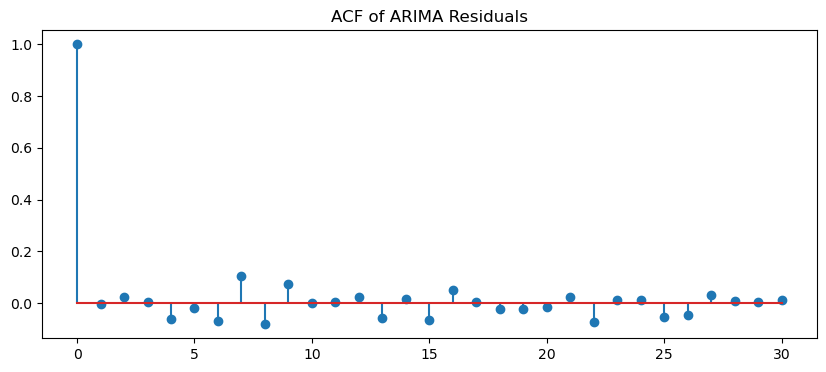

In [28]:
plt.figure(figsize=(10,4))
plt.stem(acf(residuals, nlags=30))
plt.title("ACF of ARIMA Residuals")
plt.show()

In [29]:
acorr_ljungbox(residuals, lags=[10, 20], return_df=True)

,lb_stat,lb_pvalue
10,98.627312,1.025509e-16
20,136.361158,2.472530e-19


Residual autocorrelation remains statistically detectable, but given its small magnitude, further modelling of the mean is unlikely to materially improve forecasts.

# Out-of-sample forecasting

In [17]:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning

with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=ConvergenceWarning)
    warnings.simplefilter("ignore", category=FutureWarning)
    warnings.simplefilter("ignore", category=UserWarning)

    history = train.copy()
    arima_forecasts = []

    for t in range(len(test)):
        model = ARIMA(history, order=(1, 0, 1))
        result = model.fit()
        forecast = result.forecast(steps=1)
        arima_forecasts.append(forecast.iloc[0])
        history = pd.concat([history, test.iloc[t:t+1]])

An expanding-window approach is used to mimic real-time forecasting, though gains over a static model are expected to be minimal for returns.

Warnings were suppressed for clarity after verifying they do not affect estimation validity.

In [18]:
arima_forecasts = pd.Series(
    arima_forecasts,
    index=test.index
)

# Model evaluation

In [30]:
eval_df = pd.concat([test, arima_forecasts], axis=1)
eval_df.columns = ["actual", "forecast"]
eval_df = eval_df.dropna()

In [31]:
arima_mae = mean_absolute_error(
    eval_df["actual"], eval_df["forecast"]
)
arima_rmse = root_mean_squared_error(
    eval_df["actual"], eval_df["forecast"]
)

In [40]:
pd.DataFrame({
    "Model": ["Baseline Mean", "ARIMA(1,0,1)"],
    "MAE": [baseline_mae, arima_mae],
    "RMSE": [baseline_rmse, arima_rmse]
})

,Model,MAE,RMSE
0,Baseline Mean,0.008104,0.011026
1,"ARIMA(1,0,1)",0.008264,0.011158


# Forecast visualisation

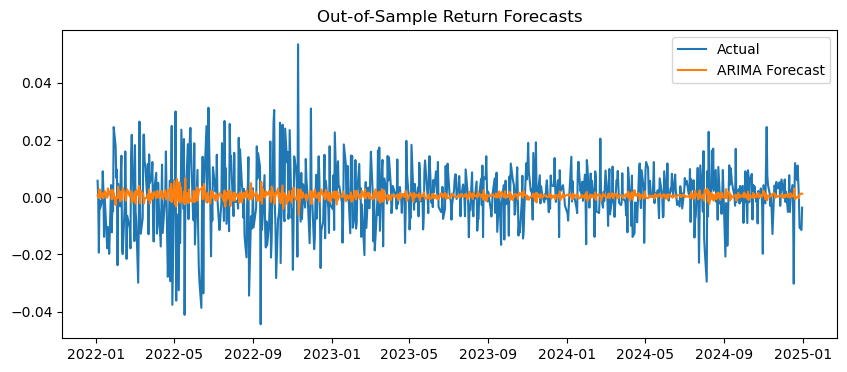

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(test.index, test, label="Actual")
plt.plot(arima_forecasts.index, arima_forecasts, label="ARIMA Forecast")
plt.legend()
plt.title("Out-of-Sample Return Forecasts")
plt.show()

# Interpretation

Consistent with the efficient market hypothesis, daily returns exhibit limited out-of-sample predictability. 

ARIMA does not materially outperform the baseline.

# Summary

**Key findings**

* Daily returns exhibit limited predictability

* ARIMA provides marginal improvement over baseline

* Forecast errors remain substantial

**Implication**

* Return forecasts should be used cautiously

* Value lies more in volatility forecasting than directional prediction

# Save forecasts

In [119]:
arima_forecasts.to_csv("../outputs/forecasts/arima_return_forecast.csv")